In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

In [2]:
df=pd.read_csv("fleet_train_imputed.csv")
df.head(50)

,Maintenance_flag,record_id,Measurement_timestamp,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Intake_Manifold_Pressure,Engine_RPM,Speed_OBD,...,GPS_Altitude,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,Accel_Ssor_Total,CO2_in_g_per_km_Inst,Trip_Time_journey,fleetid,truckid,Region
0,0,8229,22FEB16:18:18:15,35,249.188875,21.568628,88,116,1115.5,35,...,164,2.755716,310.26200,2.351502,0.045858,62.197178,11539,Fleet_00713F1,Truck_0711X1,1
1,0,932,22FEB16:16:16:38,142,243.236572,20.392157,88,135,1782.5,142,...,436,5.511435,161.02463,1.244649,0.043655,32.920940,4242,Fleet_01213F1,Truck_0081X1,1
2,0,836,22FEB16:16:15:02,128,244.015378,43.529410,81,109,1588.0,128,...,508,1.740453,158.23788,2.124100,0.073833,56.182410,4146,Fleet_01213F1,Truck_0081X1,1
3,0,570,22FEB16:16:10:36,117,244.627297,99.607840,89,128,1899.5,117,...,618,4.496170,148.82233,4.753049,0.059974,116.734042,3880,Fleet_01013F1,Truck_0171X1,1
4,0,7098,22FEB16:17:59:24,98,245.684248,73.333336,89,123,1230.5,98,...,154,3.770981,296.00378,4.031921,-0.019424,106.644250,10408,Fleet_00413F1,Truck_0641X1,2
5,0,4930,22FEB16:17:23:16,96,245.795506,43.611968,83,115,1175.0,96,...,216,2.610680,252.72640,4.753049,-0.117610,116.734042,8240,Fleet_00713F1,Truck_0421X1,1
6,0,7459,22FEB16:18:05:25,55,248.076295,39.607845,87,110,1324.0,55,...,156,1.885490,304.47766,3.408120,0.041098,90.144720,10769,Fleet_00213F1,Truck_0791X1,2
7,0,121,22FEB16:16:03:07,58,247.909408,38.823530,88,105,1410.5,58,...,789,1.160302,137.92912,4.753049,0.008018,26.569048,3431,Fleet_01213F1,Truck_0021X1,1
8,0,3594,22FEB16:17:01:00,114,244.794184,14.117647,90,113,1403.0,114,...,502,2.320604,211.98659,4.753049,-0.041719,19.719515,6904,Fleet_00913F1,Truck_0491X1,1
9,0,976,22FEB16:16:17:22,157,242.402137,54.117650,88,137,1932.0,157,...,438,5.801510,162.94577,3.422803,-0.066723,90.533070,4286,Fleet_01213F1,Truck_0081X1,1


In [3]:
df.isnull().sum()

Maintenance_flag             0
record_id                    0
Measurement_timestamp        0
Vehicle_speed_sensor         0
Vibration                    0
Engine_Load                  0
Engine_Coolant_Temp          0
Intake_Manifold_Pressure     0
Engine_RPM                   0
Speed_OBD                    0
Intake_Air_Temp              0
Mass_Air_Flow_Rate           0
Throttle_Pos_Manifold        0
Voltage_Control_Module       0
Ambient_air_temp             0
Accel_Pedal_Pos_D            0
Engine_Oil_Temp              0
Speed_GPS                    0
GPS_Longitude                0
GPS_Latitude                 0
GPS_Bearing                  0
GPS_Altitude                 0
Turbo_Boost_And_Vcm_Gauge    0
Trip_Distance                0
Litres_Per_100km_Inst        0
Accel_Ssor_Total             0
CO2_in_g_per_km_Inst         0
Trip_Time_journey            0
fleetid                      0
truckid                      0
Region                       0
dtype: int64

In [4]:
df.drop(columns= [
    'record_id', 'fleetid', 'truckid', 'Region', 'Measurement_timestamp',
    'GPS_Longitude', 'GPS_Latitude', 'GPS_Bearing', 'GPS_Altitude',
    'Maintenance_flag', 'Intake_Manifold_Pressure', 'Throttle_Pos_Manifold',
    'Intake_Air_Temp', 'Accel_Pedal_Pos_D', 'Ambient_air_temp',
    'Accel_Ssor_Total', 'Voltage_Control_Module'
],axis=1,inplace=True)


In [5]:
features_to_normalize = [
    'Engine_Load', 'Engine_RPM', 'Engine_Coolant_Temp', 'Vibration',
    'Mass_Air_Flow_Rate', 'Engine_Oil_Temp', 'Trip_Distance', 'Trip_Time_journey', 'Turbo_Boost_And_Vcm_Gauge'
]
scalers = {feature: MinMaxScaler() for feature in features_to_normalize}

In [6]:
scalers = {}
for feature in features_to_normalize:
    scalers[feature] = MinMaxScaler()
    scalers[feature].fit(df[[feature]])

# Transform features
for feature, scaler in scalers.items():
    if feature in df.columns:
        df[feature] = scaler.transform(df[[feature]])


In [7]:
def calculate_condition_score(row):
    engine_health_score = (row['Engine_Load'] + row['Engine_RPM'] + row['Engine_Coolant_Temp']) / 3
    usage_severity = row['Engine_Load'] * (row['Trip_Distance'] + row['Trip_Time_journey'])
    anomaly_flag = ((row['Vibration'] > 0.7) | (row['Engine_Coolant_Temp'] > 0.8)).astype(int)
    condition_score = 0.5 * engine_health_score + 0.3 * usage_severity + 0.2 * anomaly_flag
    return condition_score
    
df['Condition_Score'] = df.apply(calculate_condition_score, axis=1)

df.head()

,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Engine_RPM,Speed_OBD,Mass_Air_Flow_Rate,Engine_Oil_Temp,Speed_GPS,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,CO2_in_g_per_km_Inst,Trip_Time_journey,Condition_Score
0,35,0.811828,0.213439,0.600000,0.231587,35,0.111290,0.500000,36.216020,0.091503,0.993639,2.351502,62.197178,0.986216,0.500944
1,142,0.236559,0.201581,0.600000,0.577541,142,0.263722,0.500000,148.968020,0.215686,0.144925,1.244649,32.920940,0.111591,0.245366
2,128,0.311828,0.434783,0.133333,0.476660,128,0.189380,0.071429,132.408220,0.045752,0.129077,2.124100,56.182410,0.100084,0.204020
3,117,0.370968,1.000000,0.666667,0.638226,117,0.277822,0.642857,124.236080,0.169935,0.075531,4.753049,116.734042,0.068201,0.427268
4,98,0.473118,0.735178,0.666667,0.291234,98,0.140741,0.500000,100.620926,0.137255,0.912552,4.031921,106.644250,0.850653,0.671061


In [8]:
def assign_priority(score):
    if score > 0.70:
        return 'Critical'
    elif score > 0.45:
        return 'Moderate'
    else:
        return 'Low'

In [9]:
df['Priority'] = df['Condition_Score'].apply(assign_priority)
df.to_csv('fleet_train_priorities.csv', index=False)
df.head(50)

,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Engine_RPM,Speed_OBD,Mass_Air_Flow_Rate,Engine_Oil_Temp,Speed_GPS,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,CO2_in_g_per_km_Inst,Trip_Time_journey,Condition_Score,Priority
0,35,0.811828,0.213439,0.600000,0.231587,35,0.111290,0.500000,36.216020,0.091503,0.993639,2.351502,62.197178,0.986216,0.500944,Moderate
1,142,0.236559,0.201581,0.600000,0.577541,142,0.263722,0.500000,148.968020,0.215686,0.144925,1.244649,32.920940,0.111591,0.245366,Low
2,128,0.311828,0.434783,0.133333,0.476660,128,0.189380,0.071429,132.408220,0.045752,0.129077,2.124100,56.182410,0.100084,0.204020,Low
3,117,0.370968,1.000000,0.666667,0.638226,117,0.277822,0.642857,124.236080,0.169935,0.075531,4.753049,116.734042,0.068201,0.427268,Low
4,98,0.473118,0.735178,0.666667,0.291234,98,0.140741,0.500000,100.620926,0.137255,0.912552,4.031921,106.644250,0.850653,0.671061,Moderate
5,96,0.483871,0.435615,0.266667,0.262448,96,0.134315,0.214286,99.218110,0.084967,0.666434,4.753049,116.734042,0.590795,0.325088,Low
6,55,0.704301,0.395257,0.533333,0.339730,55,0.150201,0.428571,56.952040,0.052288,0.960743,3.408120,90.144720,0.893923,0.631308,Moderate
7,58,0.688172,0.387352,0.600000,0.384595,58,0.148684,0.571429,59.724094,0.019608,0.013581,4.753049,26.569048,0.014383,0.231907,Low
8,114,0.387097,0.138340,0.733333,0.380705,114,0.164034,0.785714,117.288086,0.071895,0.434746,4.753049,19.719515,0.430660,0.244646,Low
9,157,0.155914,0.541502,0.600000,0.655083,157,0.308612,0.428571,159.840580,0.228758,0.155851,3.422803,90.533070,0.116864,0.343734,Low


In [10]:
df.isnull().sum()

Vehicle_speed_sensor         0
Vibration                    0
Engine_Load                  0
Engine_Coolant_Temp          0
Engine_RPM                   0
Speed_OBD                    0
Mass_Air_Flow_Rate           0
Engine_Oil_Temp              0
Speed_GPS                    0
Turbo_Boost_And_Vcm_Gauge    0
Trip_Distance                0
Litres_Per_100km_Inst        0
CO2_in_g_per_km_Inst         0
Trip_Time_journey            0
Condition_Score              0
Priority                     0
dtype: int64

In [11]:
def calc_risk(df):
    
    df['Overstrain_Risk'] = 0.5 * df['Engine_Load'] + 0.5 * df['Engine_RPM']
    df['Heat_Dissipation_Risk'] = 0.4 * df['Engine_Coolant_Temp'] + 0.6 * df['Engine_Oil_Temp']
    df['Power_Failure_Risk'] = 0.5 * df['Mass_Air_Flow_Rate'] + 0.5 * df['Turbo_Boost_And_Vcm_Gauge']

calc_risk(df)
def assign_failure_label(row):
    if row['Condition_Score'] < 0.3:
        return 'No Failure'
    else:
        risks = {
            'Overstrain Failure': row['Overstrain_Risk'],
            'Heat Dissipation Failure': row['Heat_Dissipation_Risk'],
            'Power Failure': row['Power_Failure_Risk']
        }
        return max(risks, key=risks.get)

df['Failure_Type'] = df.apply(assign_failure_label, axis=1)

df['Failure_Type'].value_counts()

Failure_Type
Heat Dissipation Failure    4556
No Failure                  1814
Overstrain Failure          1103
Power Failure                 31
Name: count, dtype: int64

In [12]:
# df[[
#     'Engine_Load', 'Engine_RPM', 'Engine_Coolant_Temp', 'Vibration',
#     'Mass_Air_Flow_Rate', 'Engine_Oil_Temp', 'Throttle_Pos_Manifold',
#     'Accel_Ssor_Total', 'Trip_Distance', 'Trip_Time_journey']]

In [13]:
df

,Vehicle_speed_sensor,Vibration,Engine_Load,Engine_Coolant_Temp,Engine_RPM,Speed_OBD,Mass_Air_Flow_Rate,Engine_Oil_Temp,Speed_GPS,Turbo_Boost_And_Vcm_Gauge,Trip_Distance,Litres_Per_100km_Inst,CO2_in_g_per_km_Inst,Trip_Time_journey,Condition_Score,Priority,Overstrain_Risk,Heat_Dissipation_Risk,Power_Failure_Risk,Failure_Type
0,35,0.811828,0.213439,0.600000,0.231587,35,0.111290,0.500000,36.216020,0.091503,0.993639,2.351502,62.197178,0.986216,0.500944,Moderate,0.222513,0.540000,0.101396,Heat Dissipation Failure
1,142,0.236559,0.201581,0.600000,0.577541,142,0.263722,0.500000,148.968020,0.215686,0.144925,1.244649,32.920940,0.111591,0.245366,Low,0.389561,0.540000,0.239704,No Failure
2,128,0.311828,0.434783,0.133333,0.476660,128,0.189380,0.071429,132.408220,0.045752,0.129077,2.124100,56.182410,0.100084,0.204020,Low,0.455721,0.096190,0.117566,No Failure
3,117,0.370968,1.000000,0.666667,0.638226,117,0.277822,0.642857,124.236080,0.169935,0.075531,4.753049,116.734042,0.068201,0.427268,Low,0.819113,0.652381,0.223879,Overstrain Failure
4,98,0.473118,0.735178,0.666667,0.291234,98,0.140741,0.500000,100.620926,0.137255,0.912552,4.031921,106.644250,0.850653,0.671061,Moderate,0.513206,0.566667,0.138998,Heat Dissipation Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7499,85,0.543011,0.169960,0.666667,0.326245,85,0.144221,0.642857,87.228264,0.026144,0.339978,2.500408,66.135735,0.357905,0.229396,Low,0.248103,0.652381,0.085183,No Failure
7500,95,0.489247,0.435615,0.733333,0.253890,95,0.136546,0.714286,99.288025,0.045752,0.223546,4.753049,116.734042,0.222462,0.295426,Low,0.344752,0.721905,0.091149,No Failure
7501,66,0.645161,0.557312,0.666667,0.470176,66,0.216867,0.571429,65.593930,0.156863,0.883545,6.450333,170.611180,0.827760,0.568479,Moderate,0.513744,0.609524,0.186865,Heat Dissipation Failure
7502,75,0.596774,0.462451,0.533333,0.385373,75,0.162874,0.357143,72.180030,0.045752,0.775144,3.525263,93.243150,0.699389,0.434762,Low,0.423912,0.427619,0.104313,Heat Dissipation Failure


count    7504.000000
mean        0.413262
std         0.155294
min         0.057581
25%         0.306638
50%         0.401248
75%         0.506129
max         1.095487
Name: Condition_Score, dtype: float64


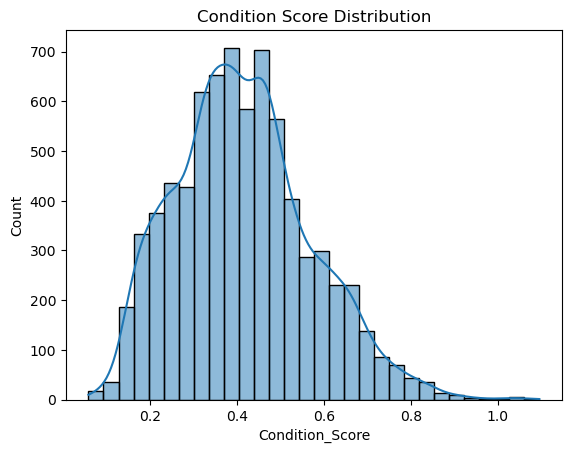

In [14]:
print(df['Condition_Score'].describe())

sns.histplot(df['Condition_Score'], bins=30, kde=True)
plt.title('Condition Score Distribution')
plt.show()


In [15]:
from sklearn.preprocessing import LabelEncoder
def encoder(df):
    lb=LabelEncoder()
    lb1=LabelEncoder()
    df['Failure_Type']=lb.fit_transform(df['Failure_Type'])
    # df['Priority']=lb1.fit_transform(df['Priority'])
    return lb
    # print(lb.inverse_transform([0,1,2,3]))
    # print(lb1.classes_)
    # print(lb1.inverse_transform([0,1,2]))

In [16]:
from sklearn.model_selection import train_test_split
lb=encoder(df)
# df.drop(columns=['Priority','GPS_Longitude','GPS_Latitude','GPS_Bearing','GPS_Altitude','Maintenance_flag','Intake_Manifold_Pressure','Throttle_Pos_Manifold','Intake_Air_Temp', 'Accel_Pedal_Pos_D', 'Ambient_air_temp', 'Accel_Ssor_Total', 'Voltage_Control_Module','Turbo_Boost_And_Vcm_Gauge','Engine_Oil_Temp','Engine_Coolant_Temp'],axis=1,inplace=True)
df.drop(columns=['Priority'],axis=1,inplace=True)
x=df.drop(columns=['Failure_Type'])
y=df['Failure_Type']

print(lb.classes_)


['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure']


<Axes: >

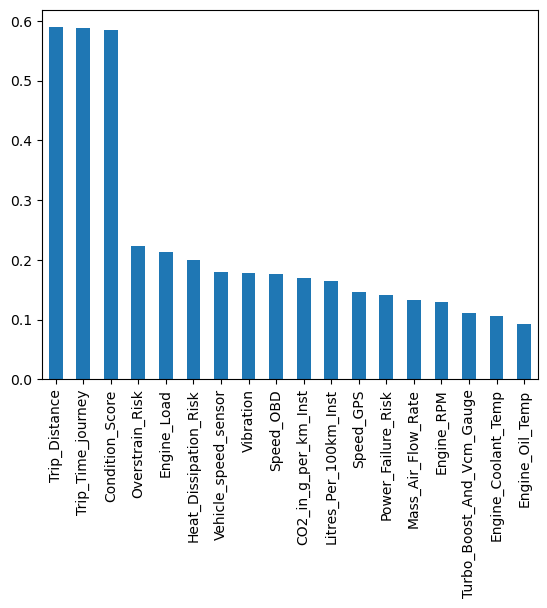

In [17]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(x, y)
mi_scores = pd.Series(mi_scores, index=x.columns)
mi_scores.sort_values(ascending=False).plot(kind='bar')


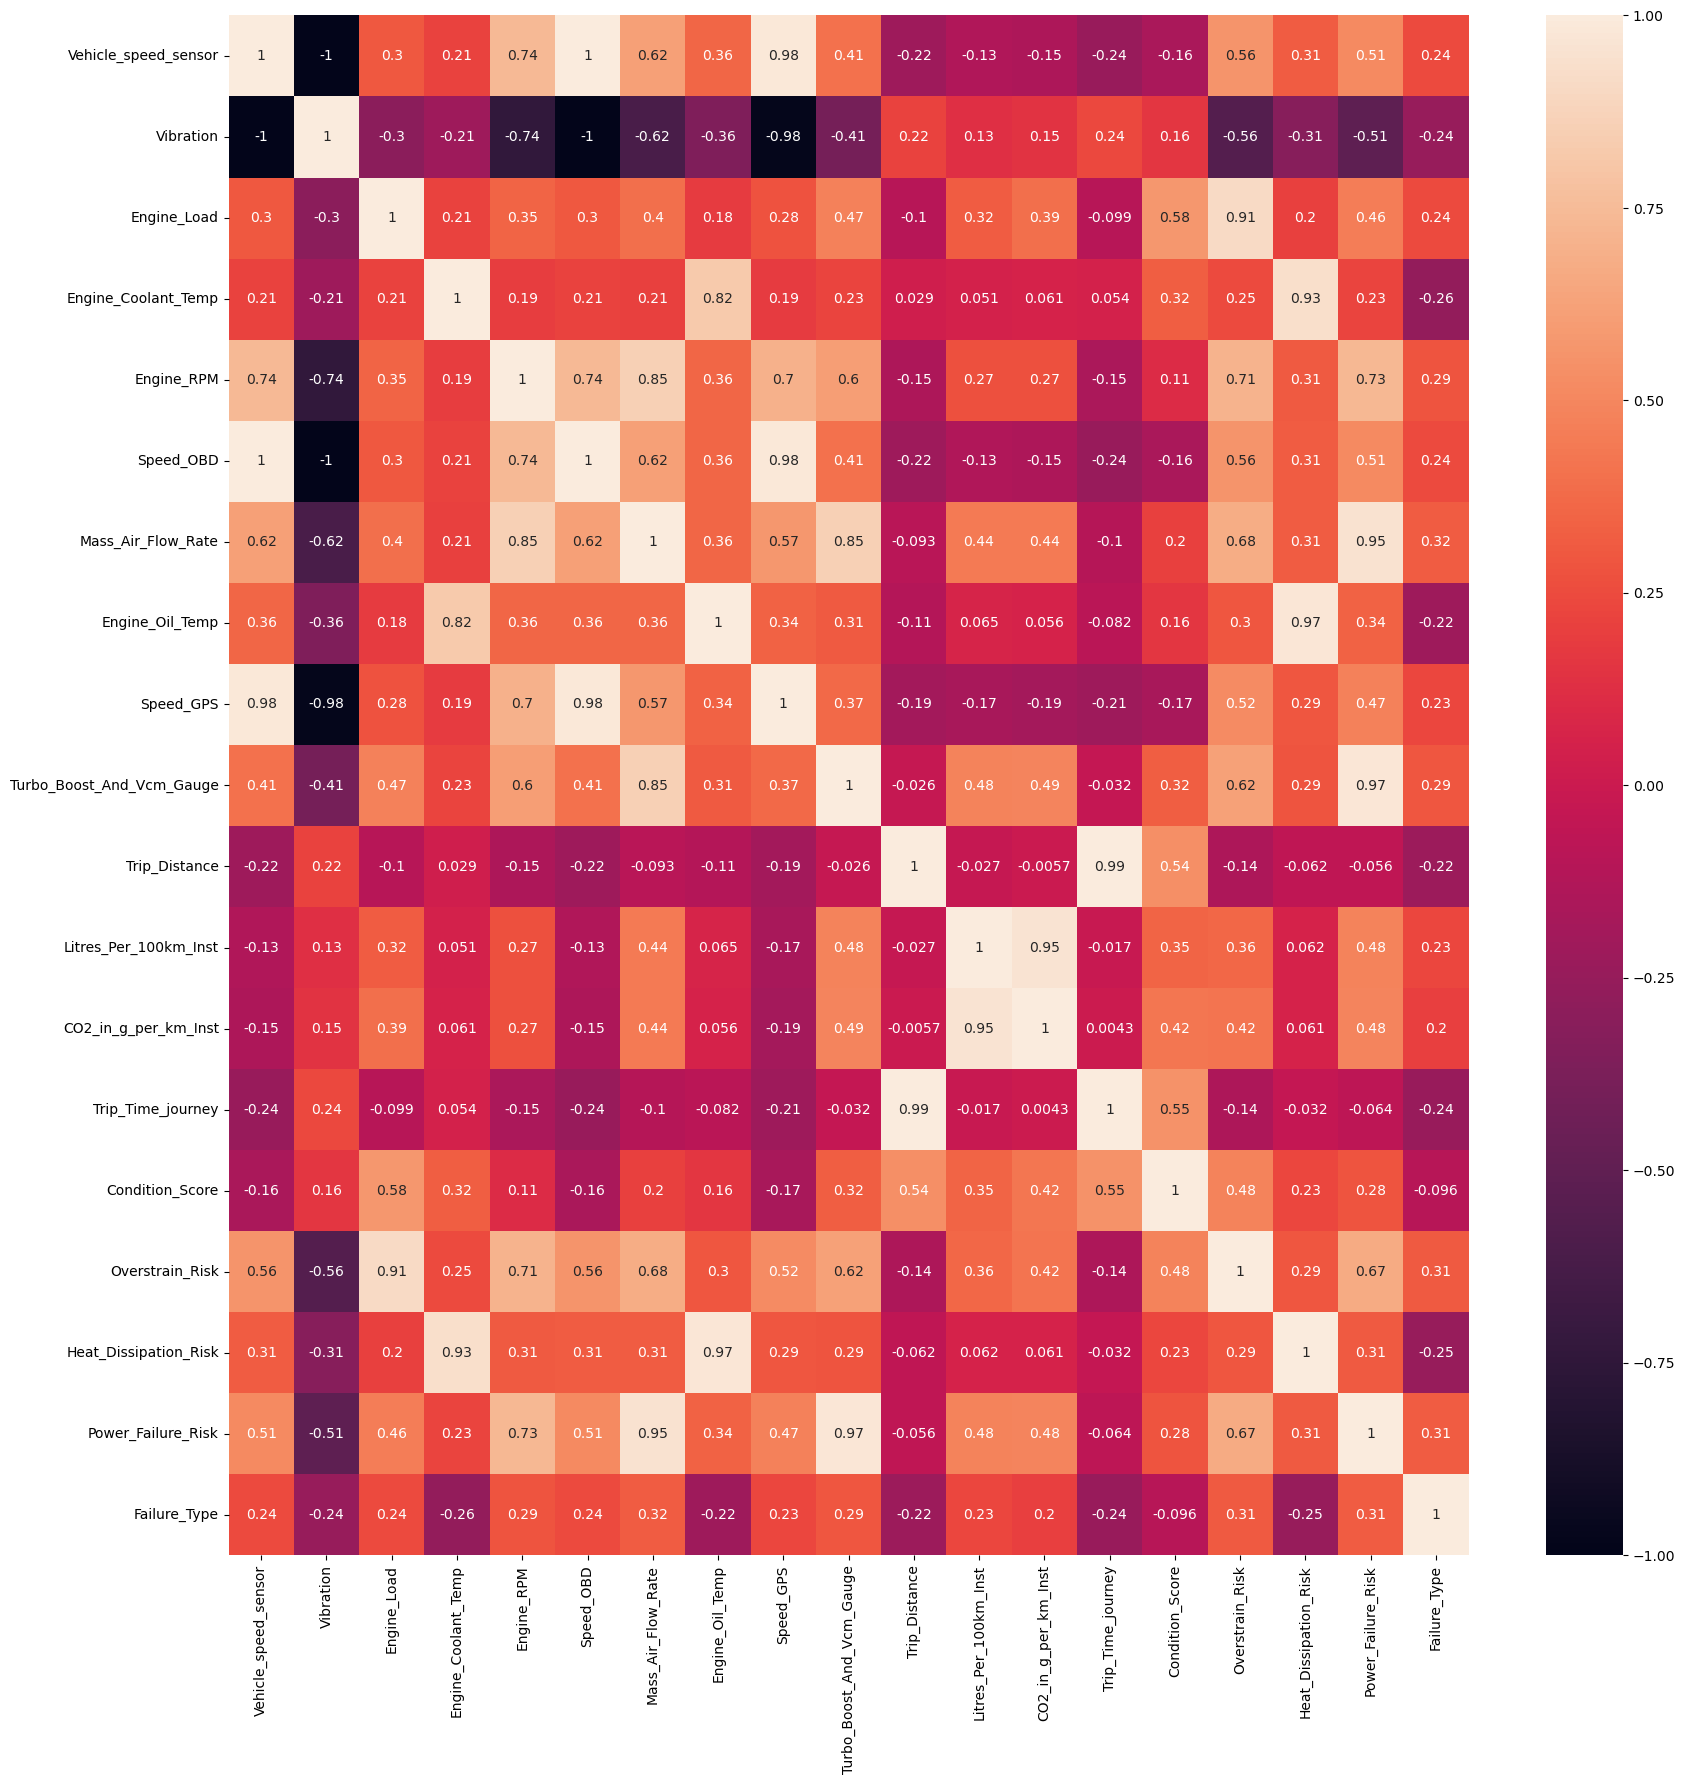

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
plt.draw()

In [19]:
xtrain,xtest, ytrain, ytest=train_test_split(x,y,test_size=0.2,random_state=42)
# xtrain,xval,ytrain,yval=train_test_split(xtrain, ytrain, test_size=0.1,random_state=42)


In [20]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 50, 100],
    'max_depth': [-1, 3, 5, 7, 10],
    'min_data_in_leaf': [10, 20, 30, 50],  # Keep this, remove min_child_samples
    'lambda_l1': [0, 0.1, 0.5, 1],  # Keep this, remove reg_alpha
    'lambda_l2': [0, 0.1, 0.5, 1],  # Keep this, remove reg_lambda
    'feature_fraction': [0.6, 0.7, 0.8, 0.9],  # Keep this, remove colsample_bytree
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9],  # Keep this, remove subsample
    'bagging_freq': [1, 5, 10],  # Keep this, remove subsample_freq
}


In [21]:
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=len(y.unique()), boosting_type='gbdt',verbose=-1)

random_search = RandomizedSearchCV(lgb_model, param_grid, n_iter=20, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
random_search.fit(xtrain, ytrain)
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'num_leaves': 50, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.1, 'lambda_l2': 1, 'lambda_l1': 0.5, 'feature_fraction': 0.8, 'bagging_freq': 10, 'bagging_fraction': 0.6}


In [22]:
best_params = random_search.best_params_
model = lgb.LGBMClassifier(objective='multiclass', num_class=len(lb.classes_), **best_params)

model.fit(xtrain, ytrain)
pred = model.predict(xtest)

# pred = [np.argmax(prob) for prob in predprob]
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(ytest, pred))
print(classification_report(ytest, pred))
print(pred)

Accuracy: 0.9893404397068621
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       889
           1       0.99      1.00      1.00       385
           2       0.97      0.97      0.97       221
           3       1.00      0.67      0.80         6

    accuracy                           0.99      1501
   macro avg       0.99      0.91      0.94      1501
weighted avg       0.99      0.99      0.99      1501

[2 2 0 ... 2 1 2]


In [23]:
xtrain.columns

Index(['Vehicle_speed_sensor', 'Vibration', 'Engine_Load',
       'Engine_Coolant_Temp', 'Engine_RPM', 'Speed_OBD', 'Mass_Air_Flow_Rate',
       'Engine_Oil_Temp', 'Speed_GPS', 'Turbo_Boost_And_Vcm_Gauge',
       'Trip_Distance', 'Litres_Per_100km_Inst', 'CO2_in_g_per_km_Inst',
       'Trip_Time_journey', 'Condition_Score', 'Overstrain_Risk',
       'Heat_Dissipation_Risk', 'Power_Failure_Risk'],
      dtype='object')

In [24]:
# params = {
#     'objective': 'multiclass',
#     'num_class': len(classes),  
#     'boosting_type': 'gbdt',
#     'metric': 'multi_logloss',
#     'learning_rate': 0.05,
#     'max_depth': 6,
#     'num_leaves': 31,
#     'min_data_in_leaf': 20,
#     'lambda_l1': 0.1,
#     'lambda_l2': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': -1,
#     'seed': 42
# }
# params['is_unbalance'] = True

In [25]:
# early_stopping_callback = lgb.early_stopping(stopping_rounds=30)
# verbose_eval_callback = lgb.log_evaluation(period=10)

# lgb_model = lgb.train(
#     params,
#     train,
#     num_boost_round=350,  
#     valid_sets=[train, val],
#     callbacks=[early_stopping_callback, verbose_eval_callback]
# )


In [26]:
df.columns

Index(['Vehicle_speed_sensor', 'Vibration', 'Engine_Load',
       'Engine_Coolant_Temp', 'Engine_RPM', 'Speed_OBD', 'Mass_Air_Flow_Rate',
       'Engine_Oil_Temp', 'Speed_GPS', 'Turbo_Boost_And_Vcm_Gauge',
       'Trip_Distance', 'Litres_Per_100km_Inst', 'CO2_in_g_per_km_Inst',
       'Trip_Time_journey', 'Condition_Score', 'Overstrain_Risk',
       'Heat_Dissipation_Risk', 'Power_Failure_Risk', 'Failure_Type'],
      dtype='object')

In [27]:
def get_user_input():
    user_records = []
    while True:
        print("\nEnter vehicle parameters:")
        vehicle_speed_sensor = float(input("Enter Vehicle Speed Sensor: "))
        vibration = float(input("Enter Vibration: "))
        engine_load = float(input("Enter Engine Load: "))
        engine_coolant_temp = float(input("Enter Engine Coolant Temp: "))
        engine_rpm = float(input("Enter Engine RPM: "))
        speed_obd = float(input("Enter Speed OBD: "))
        mass_air_flow_rate = float(input("Enter Mass Air Flow Rate: "))
        engine_oil_temp= float(input("Enter Engine Oil Temp: "))
        speed_gps = float(input("Enter Speed GPS: "))
        turbo_boost_vcm = float(input("Enter Turbo Boost & VCM Gauge: "))
        trip_distance = float(input("Enter Trip Distance: "))
        litres_per_100km_inst = float(input("Enter Litres Per 100km Inst: "))
        co2_in_g_per_km_inst = float(input("Enter CO2 in g/km Inst: "))
        trip_time_journey = float(input("Enter Trip Time Journey: "))
               
        

        user_records.append({
            'Vehicle_speed_sensor': vehicle_speed_sensor,
            'Vibration': vibration,
            'Engine_Load': engine_load,
            'Engine_Coolant_Temp':engine_coolant_temp,
            'Engine_RPM': engine_rpm,
            'Speed_OBD': speed_obd,
            'Mass_Air_Flow_Rate': mass_air_flow_rate,
            'Engine_Oil_Temp': engine_oil_temp,
            'Speed_GPS': speed_gps,
            'Turbo_Boost_And_Vcm_Gauge':turbo_boost_vcm,
            'Trip_Distance': trip_distance,
            'Litres_Per_100km_Inst': litres_per_100km_inst,
            'CO2_in_g_per_km_Inst': co2_in_g_per_km_inst,
            'Trip_Time_journey': trip_time_journey
        })

        add = input("Do you want to enter another instance? (yes/no): ").lower()
        if add != 'yes':
            break

    user_df = pd.DataFrame(user_records)
    
    for feature, scaler in scalers.items():
        if feature in features_to_normalize:
            user_df[feature] = scaler.transform(user_df[[feature]])
    

    condition_score = calculate_condition_score(user_df)
    user_df['Condition_Score'] = condition_score
    calc_risk(user_df)
    
    return user_df


In [29]:

def predict_failure():
    user_df = get_user_input()

    print("\nUser DataFrame:")
    print(user_df.head())
    feature_names = model.feature_name_
    user_df = user_df[feature_names] 
    prediction = model.predict(user_df)


    failure_types = lb.inverse_transform(prediction)

    user_df["Predicted_Failure_Type"] = failure_types

    # print("\nFinal Predicted Failures:")
    # print(user_df[["Condition_Score", "Predicted_Failure_Type"]])

    return user_df

predicted_df = predict_failure()
predicted_df = predicted_df.sort_values(by="Condition_Score", ascending=False)
print(predicted_df)


Enter vehicle parameters:


Enter Vehicle Speed Sensor:  117
Enter Vibration:  244
Enter Engine Load:  99.5
Enter Engine Coolant Temp:  89
Enter Engine RPM:  1899
Enter Speed OBD:  117
Enter Mass Air Flow Rate:  37
Enter Engine Oil Temp:  87
Enter Speed GPS:  132
Enter Turbo Boost & VCM Gauge:  4.46
Enter Trip Distance:  158
Enter Litres Per 100km Inst:  2.12
Enter CO2 in g/km Inst:  0.07
Enter Trip Time Journey:  4146
Do you want to enter another instance? (yes/no):  k



User DataFrame:
   Vehicle_speed_sensor  Vibration  Engine_Load  Engine_Coolant_Temp  \
0                 117.0   0.310342     0.998913             0.666667   

   Engine_RPM  Speed_OBD  Mass_Air_Flow_Rate  Engine_Oil_Temp  Speed_GPS  \
0    0.637967      117.0            0.277912         0.642857      132.0   

   Turbo_Boost_And_Vcm_Gauge  Trip_Distance  Litres_Per_100km_Inst  \
0                   0.168305       0.127724                   2.12   

   CO2_in_g_per_km_Inst  Trip_Time_journey  Condition_Score  Overstrain_Risk  \
0                  0.07           0.100084         0.452193          0.81844   

   Heat_Dissipation_Risk  Power_Failure_Risk  
0               0.652381            0.223108  
   Vehicle_speed_sensor  Vibration  Engine_Load  Engine_Coolant_Temp  \
0                 117.0   0.310342     0.998913             0.666667   

   Engine_RPM  Speed_OBD  Mass_Air_Flow_Rate  Engine_Oil_Temp  Speed_GPS  \
0    0.637967      117.0            0.277912         0.642857      1

In [30]:
import pickle

with open('lgbm.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scalers, f)